**Citation:**

```
@article{chen2022transformer,
  title={Transformer network for remaining useful life prediction of lithium-ion batteries},
  author={Chen, Daoquan and Hong, Weicong and Zhou, Xiuze},
  journal={Ieee Access},
  volume={10},
  pages={19621--19628},
  year={2022},
  publisher={IEEE}
}
```

In [19]:
!git clone https://github.com/Yecgaa1/RUL_Class

fatal: destination path 'RUL_Class' already exists and is not an empty directory.


In [20]:
import numpy as np
import random
import math
import os
import scipy.io
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import transformers
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm
from math import sqrt
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# 1. load data

In [21]:
# convert str to datatime
def convert_to_time(hmm):
    year, month, day, hour, minute, second = int(hmm[0]), int(hmm[1]), int(hmm[2]), int(hmm[3]), int(hmm[4]), int(hmm[5])
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)


# load .mat data
def loadMat(matfile):
    data = scipy.io.loadmat(matfile)
    filename = matfile.split("/")[-1].split(".")[0]
    col = data[filename]
    col = col[0][0][0][0]
    size = col.shape[0]

    data = []
    for i in range(size):
        k = list(col[i][3][0].dtype.fields.keys())
        d1, d2 = {}, {}
        if str(col[i][0][0]) != 'impedance':
            for j in range(len(k)):
                t = col[i][3][0][0][j][0];
                l = [t[m] for m in range(len(t))]
                d2[k[j]] = l
        d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2
        data.append(d1)

    return data


# get capacity data
def getBatteryCapacity(Battery):
    cycle, capacity = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            capacity.append(Bat['data']['Capacity'][0])
            cycle.append(i)
            i += 1
    return [cycle, capacity]


# get the charge data of a battery
def getBatteryValues(Battery, Type='charge'):
    data=[]
    for Bat in Battery:
        if Bat['type'] == Type:
            data.append(Bat['data'])
    return data

## 1.1 Extract raw data

In [22]:
Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
dir_path = 'datasets/NASA/'

Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + '.mat ...')
    path = dir_path + name + '.mat'
    data = loadMat(path)
    Battery[name] = getBatteryCapacity(data)

Load Dataset B0005.mat ...


<ipython-input-21-17683da78544>:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2


Load Dataset B0006.mat ...
Load Dataset B0007.mat ...
Load Dataset B0018.mat ...


## or 1.1 load the extracted data

**note: If the above read fails, please load the .npy file.**

In [23]:
Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
Battery = np.load('datasets/NASA/NASA.npy', allow_pickle=True)
Battery = Battery.item()

## 1.2 plot figures for capacity degradation

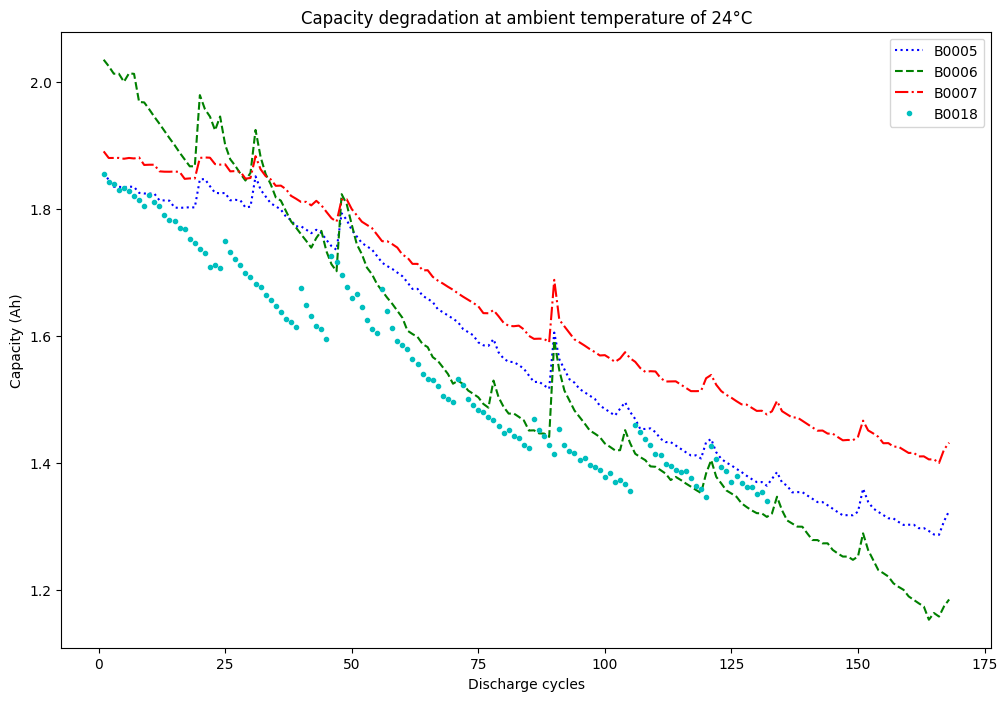

In [24]:
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
c = 0
for name,color in zip(Battery_list, color_list):
    df_result = Battery[name]
    ax.plot(df_result[0], df_result[1], color, label=name)
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 24°C')
plt.legend()

# 2. data processing and model

## 2.1 data processing for model training

In [25]:
def build_instances(sequence, window_size):
    #sequence: list of capacity
    x, y = [],[]
    for i in range(len(sequence) - window_size):
        features = sequence[i:i+window_size]
        target = sequence[i+window_size]

        x.append(features)
        y.append(target)

    return np.array(x).astype(np.float32), np.array(y).astype(np.float32)


def split_dataset(data_sequence, train_ratio=0.0, capacity_threshold=0.0):
    if capacity_threshold > 0:
        max_capacity = max(data_sequence)
        capacity = max_capacity * capacity_threshold
        point = [i for i in range(len(data_sequence)) if data_sequence[i] < capacity]
    else:
        point = int(train_ratio + 1)
        if 0 < train_ratio <= 1:
            point = int(len(data_sequence) * train_ratio)
    train_data, test_data = data_sequence[:point], data_sequence[point:]

    return train_data, test_data


# leave-one-out evaluation: one battery is sampled randomly; the remainder are used for training.
def get_train_test(data_dict, name, window_size=8):
    data_sequence=data_dict[name][1]
    train_data, test_data = data_sequence[:window_size+1], data_sequence[window_size+1:]
    train_x, train_y = build_instances(train_data, window_size)
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_instances(v[1], window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]

    return train_x, train_y, list(train_data), list(test_data)


def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0

    for i in range(len(y_test)-1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1
            break

    for i in range(len(y_predict)-1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break

    score = abs(true_re - pred_re)/true_re
    if score > 1: score = 1

    return score


def evaluation(y_test, y_predict):
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return rmse


def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

## 2.2 build net

In [26]:
class Autoencoder(nn.Module):
    def __init__(self, input_size=16, hidden_dim=8, noise_level=0.01):
        '''
        Args:
            input_size: the feature size of input data (required).
            hidden_dim: the hidden size of AutoEncoder (required).
            noise_level: the noise level added in Autoencoder (optional).
        '''
        super(Autoencoder, self).__init__()
        self.noise_level = noise_level
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, input_size)

    def encoder(self, x):
        x = self.fc1(x)
        h1 = F.relu(x)
        return h1

    def mask(self, x):
        corrupted_x = x + self.noise_level * torch.randn_like(x)
        return corrupted_x

    def decoder(self, x):
        h2 = self.fc2(x)
        return h2

    def forward(self, x):
        out = self.mask(x)
        encode = self.encoder(out)
        decode = self.decoder(encode)
        return encode, decode


class PositionalEncoding(nn.Module):
    def __init__(self, feature_len, feature_size, dropout=0.0):
        '''
        Args:
            feature_len: the feature length of input data (required).
            feature_size: the feature size of input data (required).
            dropout: the dropout rate (optional).
        '''
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(feature_len, feature_size)
        position = torch.arange(0, feature_len, dtype=torch.float).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, feature_size, 2).float() * (-math.log(10000.0) / feature_size))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe

        return x


class Net(nn.Module):
    def __init__(self, feature_size=16, hidden_dim=32, feature_num=1, num_layers=1, nhead=1, dropout=0.0, noise_level=0.01):
        '''
        Args:
            feature_size: the feature size of input data (required).
            hidden_dim: the hidden size of Transformer block (required).
            feature_num: the number of features, such as capacity, voltage, and current; set 1 for only sigle feature (optional).
            num_layers: the number of layers of Transformer block (optional).
            nhead: the number of heads of multi-attention in Transformer block (optional).
            dropout: the dropout rate of Transformer block (optional).
            noise_level: the noise level added in Autoencoder (optional).
        '''
        super(Net, self).__init__()
        self.auto_hidden = int(feature_size / 2)
        input_size = self.auto_hidden

        if feature_num == 1:
            # Transformer treated as an Encoder when modeling for a sigle feature like only capacity data
            self.pos = PositionalEncoding(feature_len=feature_num, feature_size=input_size)
            encoder_layers = nn.TransformerEncoderLayer(d_model=input_size, nhead=nhead, dim_feedforward=hidden_dim, dropout=dropout, batch_first=True)
        elif feature_num > 1:
            # Transformer treated as a sequence model when modeling for multi-features like capacity, voltage, and current data
            self.pos = PositionalEncoding(feature_len=input_size, feature_size=feature_num)
            encoder_layers = nn.TransformerEncoderLayer(d_model=feature_num, nhead=nhead, dim_feedforward=hidden_dim, dropout=dropout, batch_first=True)
        self.cell = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        self.linear = nn.Linear(feature_num*self.auto_hidden, 1)
        self.autoencoder = Autoencoder(input_size=feature_size, hidden_dim=self.auto_hidden, noise_level=noise_level)

    def forward(self, x):
        batch_size, feature_num, feature_size  = x.shape
        out, decode = self.autoencoder(x)
        if feature_num > 1:
            out = out.reshape(batch_size, -1, feature_num)
        out = self.pos(out)
        out = self.cell(out)              # sigle feature: (batch_size, feature_num, auto_hidden) or multi-features: (batch_size, auto_hidden, feature_num)
        out = out.reshape(batch_size, -1) # (batch_size, feature_num*auto_hidden)
        out = self.linear(out)            # out shape: (batch_size, 1)

        return out, decode

## 2.3 train for model

In [27]:
def train(lr=0.01, feature_size=8, feature_num=1, hidden_dim=32, num_layers=1, nhead=1, dropout=0.0, epochs=1000,
          weight_decay=0.0, seed=0, alpha=0.0, noise_level=0.0, metric='re', device='cpu'):
    '''
        Args:
            lr: learning rate for training (required).
            feature_size: the feature size of input data (required).
            feature_num: the number of features, such as capacity, voltage, and current; set 1 for only sigle feature (optional).
            hidden_dim: the hidden size of Transformer block (required).
            num_layers: the number of layers of Transformer block (optional).
            nhead: the number of heads of multi-attention in Transformer block (optional).
            dropout: the dropout rate of Transformer block (optional).
            epochs:
            weight_decay:
            seed: (optional).
            alpha: (optional).
            noise_level: the noise level added in Autoencoder (optional).
            metric: (optional).
            device: the device for training (optional).
        '''
    score_list, fixed_result_list, moving_result_list = [], [], []
    setup_seed(seed)
    for i in range(4):
        name = Battery_list[i]
        train_x, train_y, train_data, test_data = get_train_test(Battery, name, feature_size)
        test_sequence = train_data + test_data
        # print('sample size: {}'.format(len(train_x)))

        model = Net(feature_size=feature_size, hidden_dim=hidden_dim, feature_num=K, num_layers=num_layers,
                    nhead=nhead, dropout=dropout, noise_level=noise_level)
        model = model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.MSELoss()

        test_x = train_data.copy()
        loss_list, y_fixed_slice, y_moving_slice = [0], [], []
        rmse, re = 1, 1
        score_, score = [1],[1]
        for epoch in range(epochs):
            x, y = np.reshape(train_x/Rated_Capacity,(-1, feature_num, feature_size)), np.reshape(train_y/Rated_Capacity,(-1,1))
            x, y = torch.from_numpy(x).to(device), torch.from_numpy(y).to(device)
            x = x.repeat(1, K, 1)
            output, decode = model(x)
            output = output.reshape(-1, 1)
            loss = criterion(output, y) + alpha * criterion(decode, x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (epoch + 1)%10 == 0:
                test_x = train_data.copy()
                fixed_point_list, moving_point_list = [], []
                t = 0
                while (len(test_x) - len(train_data)) < len(test_data):
                    x = np.reshape(np.array(test_x[-feature_size:])/Rated_Capacity,(-1, feature_num, feature_size)).astype(np.float32)
                    x = torch.from_numpy(x).to(device)
                    x = x.repeat(1, K, 1)
                    pred, _ = model(x)
                    next_point = pred.data.cpu().numpy()[0,0] * Rated_Capacity
                    test_x.append(next_point)      # The test values are added to the original sequence to continue to predict the next point
                    fixed_point_list.append(next_point) # Saves the predicted value of the last point in the output sequence

                    x = np.reshape(np.array(test_sequence[t:t+feature_size])/Rated_Capacity,(-1, 1, feature_size)).astype(np.float32)
                    x = torch.from_numpy(x).to(device)
                    x = x.repeat(1, K, 1)
                    pred, _ = model(x)
                    next_point = pred.data.cpu().numpy()[0,0] * Rated_Capacity
                    moving_point_list.append(next_point) # Saves the predicted value of the last point in the output sequence
                    t += 1

                y_fixed_slice.append(fixed_point_list)             # Save all the predicted values
                y_moving_slice.append(moving_point_list)

                loss_list.append(loss)
                rmse = evaluation(y_test=test_data, y_predict=y_fixed_slice[-1])
                re = relative_error(y_test=test_data, y_predict=y_fixed_slice[-1], threshold=Rated_Capacity*0.7)
                #print('epoch:{:<2d} | loss:{:<6.4f} | RMSE:{:<6.4f} | RE:{:<6.4f}'.format(epoch, loss, rmse, re))

            if metric == 're':
                score = [re]
            elif metric == 'rmse':
                score = [rmse]
            else:
                score = [re, rmse]
            if (loss < 1e-3) and (score_[0] < score[0]):
                break
            score_ = score.copy()

        score_list.append(score_)
        fixed_result_list.append(train_data.copy() + y_fixed_slice[-1])
        moving_result_list.append(train_data.copy() + y_moving_slice[-1])

    return score_list, fixed_result_list, moving_result_list

## 2.4 setting and training for overall performance

In [30]:
Rated_Capacity = 2.0
feature_size = 16
feature_num = 1
dropout = 0.0
epochs = 5000
nhead = 1
hidden_dim = 16
num_layers = 2
lr = 0.01
weight_decay = 0.0
noise_level = 0.0
alpha = 0.01
metric = 're'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

K = 16

SCORE = []
for seed in tqdm(range(5)):
    print('seed:{}'.format(seed))
    score_list, _, _ = train(lr=lr, feature_size=feature_size, feature_num=feature_num, hidden_dim=hidden_dim, num_layers=num_layers,
                             nhead=nhead, weight_decay=weight_decay, epochs=epochs, seed=seed, dropout=dropout, alpha=alpha,
                             noise_level=noise_level, metric=metric, device=device)
    print(np.array(score_list))
    print(metric + 'for this seed: {:<6.4f}'.format(np.mean(np.array(score_list))))
    for s in score_list:
        SCORE.append(s)
    print('------------------------------------------------------------------')
print(metric + ' mean: {:<6.4f}'.format(np.mean(np.array(SCORE))))

  0%|          | 0/5 [00:00<?, ?it/s]

seed:0


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


[[0.09433962]
 [0.61111111]
 [0.0397351 ]
 [0.05128205]]
refor this seed: 0.1991
------------------------------------------------------------------
seed:1


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


[[0.08490566]
 [0.35555556]
 [0.1192053 ]
 [0.15384615]]
refor this seed: 0.1784
------------------------------------------------------------------
seed:2


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


[[0.02830189]
 [0.21111111]
 [1.        ]
 [0.3974359 ]]
refor this seed: 0.4092
------------------------------------------------------------------
seed:3


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


[[0.16981132]
 [0.63333333]
 [0.60264901]
 [0.14102564]]
refor this seed: 0.3867
------------------------------------------------------------------
seed:4


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


[[0.43396226]
 [0.24444444]
 [0.50993377]
 [0.6025641 ]]
refor this seed: 0.4477
------------------------------------------------------------------
re mean: 0.3242


## 2.5 prediction for figures

In [31]:
Rated_Capacity = 2.0
feature_size = 16
feature_num = 1
dropout = 0.0
epochs = 5000
nhead = 1
hidden_dim = 16
num_layers = 2
lr = 0.01
weight_decay = 0.0
noise_level = 0.0
alpha = 0.01
metric = 're'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
K = 16
seed = 0

SCORE = []
print('seed:{}'.format(seed))
score_list, fixed_result_list, moving_result_list = train(lr=lr, feature_size=feature_size, feature_num=feature_num,
                                                           hidden_dim=hidden_dim, num_layers=num_layers, nhead=nhead,
                                                           weight_decay=weight_decay, epochs=epochs, seed=seed, dropout=dropout,
                                                           alpha=alpha, noise_level=noise_level, metric=metric, device=device)
print(np.array(score_list))
print(metric + 'for this seed: {:<6.4f}'.format(np.mean(np.array(score_list))))

seed:0


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


[[0.09433962]
 [0.61111111]
 [0.0397351 ]
 [0.05128205]]
refor this seed: 0.1991


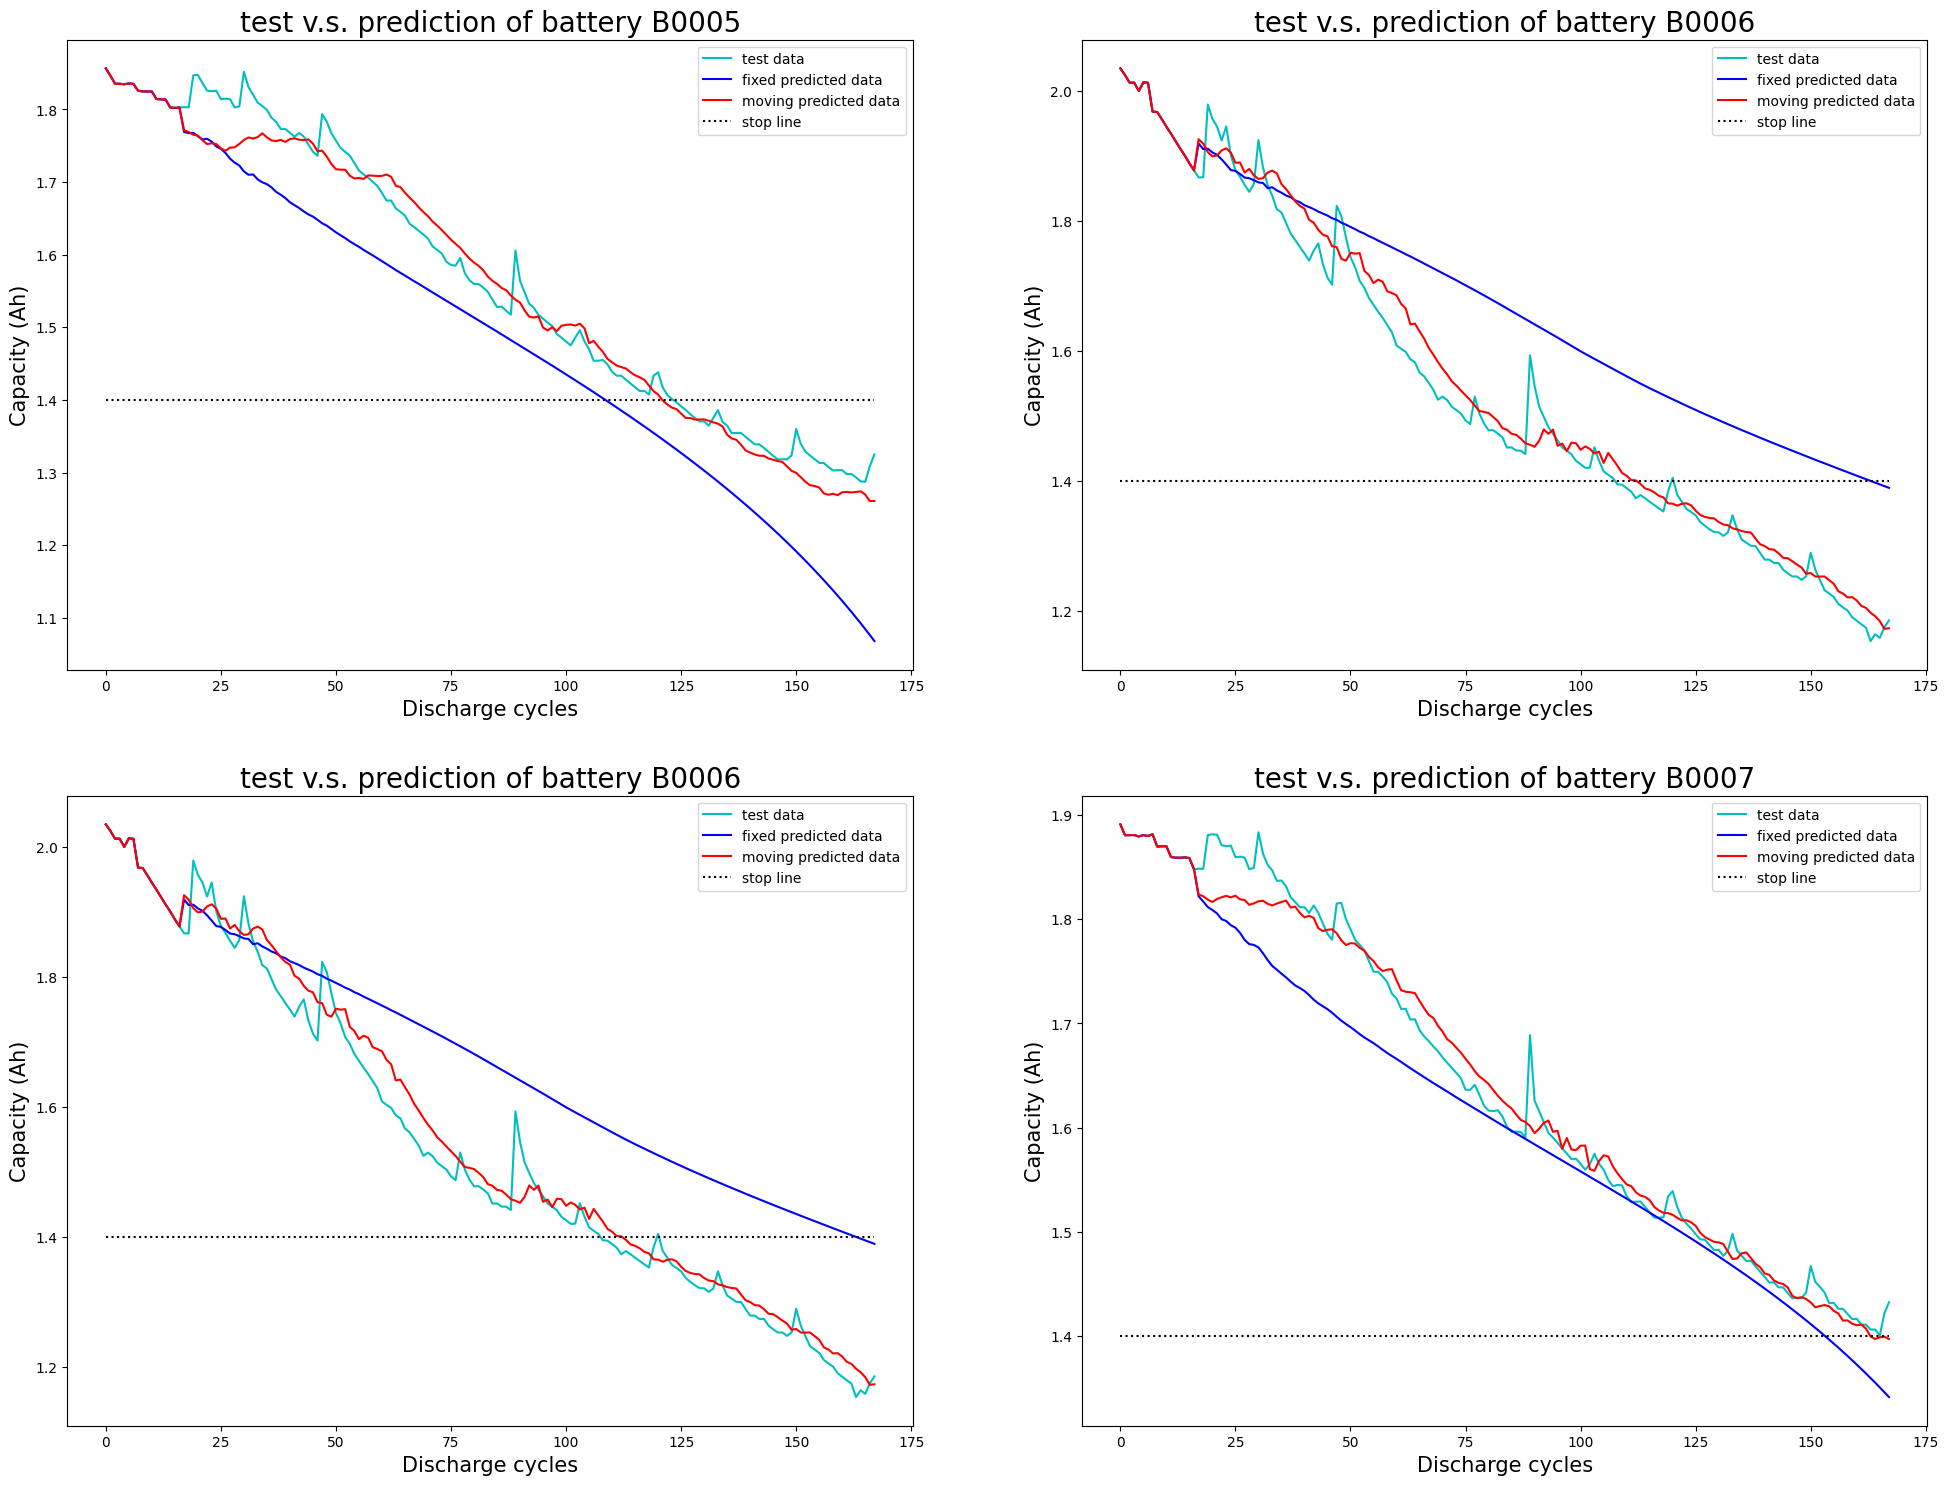

In [32]:
fig,ax = plt.subplots(2, 2, figsize=(24, 18))

for i in range(2):
    for j in range(2):
        t = i + j
        battery_name = Battery_list[t]
        test_data = Battery[battery_name][1]
        fixed_predict_data = fixed_result_list[t]
        moving_predict_data = moving_result_list[t]
        x = [t for t in range(len(test_data))]
        threshold = [Rated_Capacity*0.7] * len(test_data)
        ax[i][j].plot(x, test_data, 'c', label='test data')
        # ax[i][j].plot(x, fixed_predict_data, 'b', label='fixed predicted data')
        ax[i][j].plot(x, moving_predict_data, 'r', label='moving predicted data')
        ax[i][j].plot(x, threshold, 'black', ls=':', label='stop line')
        ax[i][j].legend()
        ax[i][j].set_xlabel('Discharge cycles', fontsize=15)
        ax[i][j].set_ylabel('Capacity (Ah)', fontsize=15)
        ax[i][j].set_title('test v.s. prediction of battery ' + battery_name, fontsize=20)
plt.show()

# 3. use grid-search to determ parameters

In [ ]:
Rated_Capacity = 2.0
feature_size = 16
feature_num = 1
dropout = 0.0
epochs = 2000
nhead = 1

weight_decay = 0.0
noise_level = 0.0
alpha = 0.0
metric = 're'

states = {}
for K in tqdm([1, 4, 8, 16, 32, 64, 128], position=0):
    for lr in tqdm([0.001, 0.01], position=1):
        for num_layers in tqdm([1, 2], position=2):
            for hidden_dim in [16, 32]:
                for alpha in [0.0, 1e-4, 1e-3, 1e-2]:
                    show_str = 'K={}, lr={}, num_layers={}, hidden_dim={}, alpha={}'.format(K, lr, num_layers, hidden_dim, alpha)
                    print(show_str)
                    SCORE = []
                    for seed in range(5):
                        print('seed:{}'.format(seed))
                        score_list, _, _ = train(lr=lr, feature_size=feature_size, feature_num=feature_num, hidden_dim=hidden_dim,
                                                 num_layers=num_layers, nhead=nhead, weight_decay=weight_decay, epochs=epochs,
                                                 seed=seed, dropout=dropout, alpha=alpha, noise_level=noise_level, metric=metric)
                        print(np.array(score_list))
                        print(metric + ': {:<6.4f}'.format(np.mean(np.array(score_list))))
                        print('------------------------------------------------------------------')
                        for s in score_list:
                            SCORE.append(s)

                    print(metric + ' mean: {:<6.4f}'.format(np.mean(np.array(SCORE))))
                    states[show_str] = np.mean(np.array(SCORE))
                    print('===================================================================')

min_key = min(states, key = states.get)
print('optimal parameters: {}, result: {}'.format(min_key, states[min_key]))